In [1]:
# Imports
import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))

from helpers import *
import numpy as np
import capytaine as cpt
import logging

import matplotlib.pyplot as plt

In [2]:
file1 = "data/MEEM-sweep.pkl"
file2 = "data/CPT.pkl"
file3 = "data/pair-comparison.pkl"

In [3]:
# helper functions
def sweep_normal_MEEM(h, d, a, heave_vectors, NMK, m0s, rho):
  output = {m0 : {} for m0 in m0s}
  prob = ConvergenceProblemNeighbors(h, d, a, heave_vectors[0], NMK, m0s[0], rho)
  base_a_matrix = prob.a_matrix()
  for heave_vector in heave_vectors:
    prob.heaving = heave_vector
    heaving_region = heave_vector.index(1)
    base_b_vector = prob.b_vector()
    for m0 in m0s:
      prob.change_m0(m0)
      a_matrix = prob.a_matrix_from_old(base_a_matrix)
      b_vector = prob.b_vector_from_old(base_b_vector)
      x = prob.get_unknown_coeffs(a_matrix, b_vector)
      am, dp = prob.hydro_coeffs(x, "capytaine")
      output[m0][heaving_region] = {}
      output[m0][heaving_region]["am"] = am
      output[m0][heaving_region]["dp"] = dp
  return output

# check that the NMK = nmk_max case is <1% off from the NMK = big_nmk case
def check_fast_convergence(spar_rad, float_rad, spar_depth, float_depth, h, m0s, rho, nmk_max, big_nmk):
  heave_vectors = [[1, 0], [0, 1]]
  a = [spar_rad, float_rad]
  d = [spar_depth, float_depth]
  big_NMK = 3 * [big_nmk]
  max_NMK = 3 * [nmk_max]

  print(h, d, a)

  dict1 = sweep_normal_MEEM(h, d, a, heave_vectors, big_NMK, m0s, rho)
  dict2 = sweep_normal_MEEM(h, d, a, heave_vectors, max_NMK, m0s, rho)
  hydros = ["am", "dp"]

  for m0 in m0s:
    for heave_vector in heave_vectors:
      heaving_region = heave_vector.index(1)
      for hydro in hydros:
        hydro1, hydro2 = dict1[m0][heaving_region][hydro], dict2[m0][heaving_region][hydro]
        converges = ((abs(hydro1 - hydro2)/hydro1) < 0.01)
        print(converges, m0, heaving_region, hydro)
  return dict1, dict2

def generate_and_store(spar_rad, float_rad, spar_depth, float_depth, h, m0s, rho, nmk_max, big_nmk):
  a = [spar_rad, float_rad]
  d = [spar_depth, float_depth]
  big_NMK = 3 * [big_nmk]
  print(h, d, a)

  mks = []
  prob = ConvergenceProblemNeighbors(h, d, a, [1, 0], big_NMK, m0s[0], rho)
  for m0 in m0s:
    prob.change_m0(m0)
    mks.append(prob.m_k)

  # result is dict w/ form {m0 : {heaving_region : {"am" : val, "dp" : val, region : {"ams" : [vals], "dps" [vals]}}}}
  result = prob.full_convergence_study(nmk_max, m0s, mks)
  result["h"] = h
  result["d"] = d
  result["a"] = a
  result["m0s"] = m0s
  return result

In [4]:
# base variables and variable ranges
base_spar_rad = 3
base_float_rad = 10
base_spar_depth = 35
base_float_depth = 3
base_h = 70
rho = 1023

# Do a frequency sweep for all geoms
m0s = (list(np.round(np.linspace(0.001, 0.009, 9), 3))
      + list(np.round(np.linspace(0.01, 0.09, 9), 3))
      + list(np.round(np.linspace(0.1, 1.1, 11), 3)))

sub_m0s = [m0s[0], m0s[9], m0s[18], m0s[27]]

# Variations
spar_rads = np.linspace(1.5, 6, 10)
float_rads = np.linspace(5, 15, 11)
spar_depths = np.linspace(20, 50, 13)
float_depths = np.linspace(1.5, 6, 10)
hs = np.linspace(40, 100, 13)

# Convergence
big_nmk, nmk_max = 200, 150
nmk_for_true = 1000

In [5]:
# # Check that each config converges by NMK = 150.
# # Initially run to cap m0. No need to rerun.
# all_data = [[], [], [], [], []]

# for spar_rad in spar_rads:
#   all_data[0].append(check_fast_convergence(spar_rad, base_float_rad, base_spar_depth, base_float_depth,
#                                             base_h, m0s, rho, nmk_max, big_nmk))
# for float_rad in float_rads:
#   all_data[1].append(check_fast_convergence(base_spar_rad, float_rad, base_spar_depth, base_float_depth,
#                                             base_h, m0s, rho, nmk_max, big_nmk))
# for spar_depth in spar_depths:
#   all_data[2].append(check_fast_convergence(base_spar_rad, base_float_rad, spar_depth, base_float_depth,
#                                             base_h, m0s, rho, nmk_max, big_nmk))
# for float_depth in float_depths:
#   all_data[3].append(check_fast_convergence(base_spar_rad, base_float_rad, base_spar_depth, float_depth,
#                                             base_h, m0s, rho, nmk_max, big_nmk))
# for h in hs:
#   all_data[4].append(check_fast_convergence(base_spar_rad, base_float_rad, base_spar_depth, base_float_depth,
#                                             h, m0s, rho, nmk_max, big_nmk))

In [6]:
# # MEEM generation
# all_data = [[], [], [], [], []]

# for spar_rad in spar_rads:
#   all_data[0].append(generate_and_store(spar_rad, base_float_rad, base_spar_depth, base_float_depth,
#                                         base_h, m0s, rho, nmk_max, big_nmk))
#   update_data_file(all_data, file1)
# for float_rad in float_rads:
#   all_data[1].append(generate_and_store(base_spar_rad, float_rad, base_spar_depth, base_float_depth,
#                                         base_h, m0s, rho, nmk_max, big_nmk))
#   update_data_file(all_data, file1)
# for spar_depth in spar_depths:
#   all_data[2].append(generate_and_store(base_spar_rad, base_float_rad, spar_depth, base_float_depth,
#                                         base_h, m0s, rho, nmk_max, big_nmk))
#   update_data_file(all_data, file1)
# for float_depth in float_depths:
#   all_data[3].append(generate_and_store(base_spar_rad, base_float_rad, base_spar_depth, float_depth,
#                                         base_h, m0s, rho, nmk_max, big_nmk))
#   update_data_file(all_data, file1)
# for h in hs:
#   all_data[4].append(generate_and_store(base_spar_rad, base_float_rad, base_spar_depth, base_float_depth,
#                                         h, m0s, rho, nmk_max, big_nmk))
#   update_data_file(all_data, file1)

In [7]:
# Capytaine helper functions
solver = cpt.BEMSolver() 
logging.getLogger("capytaine").setLevel(logging.ERROR)

def deafen(function, *args, **kwargs):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args, **kwargs)
    sys.stdout = real_stdout
    return output

def get_points(a, d_in, d_out): # These points define the outline of the body
    pt_lst = [(0, - d_in[0])]
    for i in range(len(a)):
        pt_lst.append((a[i], - d_out[i]))
        if i < (len(a) - 1): # not last body region
            if d_out[i] != d_in[i + 1]: # vertical face exists
                pt_lst.append((a[i], - d_in[i + 1]))
        else: # need vertical face to water surface
            pt_lst.append((a[i], 0))
    return pt_lst

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heave_status, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heave_status:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    heave_region = -1
    for i in range(len(pts) - 1):
        p1, p2 = pts[i], pts[i + 1]
        if p1[0] != p2[0]: # face spans some horizontal distance
            heave_region += 1 # advance to next region
            # make a horizontal face
            meshes, mask, panel_ct = faces_and_heaves(heaving[heave_region], p1, p2, f_densities[i], t_densities[heave_region], meshes, mask, panel_ct)
        else: # make a vertical face
            if p1[1] <= p2[1]: # body on inside
                j = heave_region # defer to variables of inner region
            else: # body on outside
                j = heave_region + 1 # defer to variables of outer region
            meshes, mask, panel_ct = faces_and_heaves(heaving[j], p1, p2, f_densities[i], t_densities[j], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, mesh = meshes) # unclosed boundary warnings
    return body, panel_ct, mask

def construct_and_solve(a, d, heaving, t_densities, f_densities, h, m0, rho,
                        show_mesh = False, show_pc = False, show_hydros = False):
    pt_lst = get_points(a, d, d)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    if show_mesh:
        body.show_matplotlib()
        plt.show()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result_r = solver.solve(rad_problem, keep_details = True)

    # diff_problems = [cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho) for m0 in m0s]
    # result_ds = solver.solve_all(diff_problems, keep_details = True)

    if show_pc: print("Panel Count: ", panel_count)
    if show_hydros:
        print(result_r.added_mass)
        print(result_r.radiation_damping)
    # if show_phase: print("Excitation Phase: ", self.get_excitation_phase(result_d))
    
    result = {"cpt am" : result_r.added_mass["Heave"],
              "cpt dp" : result_r.radiation_damping["Heave"],
              "Panel Count" : panel_count}

    return result

In [8]:
# Capytaine - test variables
spar_rads_cpt = [spar_rads[0], spar_rads[-1]]
float_rads_cpt = [float_rads[0], float_rads[-1]]
spar_depths_cpt = [spar_depths[0], spar_depths[-1]]
float_depths_cpt = [float_depths[0], float_depths[-1]]
hs_cpt = [hs[0], hs[-1]]

In [9]:
def populate_with_basic_data(spar_rad, float_rad, spar_depth, float_depth, h, m0s, rho, big_nmk):
  heave_vectors = [[1, 0], [0, 1]]
  a = [spar_rad, float_rad]
  d = [spar_depth, float_depth]
  NMK = 3 * [big_nmk]

  print(h, d, a)

  result = sweep_normal_MEEM(h, d, a, heave_vectors, NMK, m0s, rho)
  result["h"] = h
  result["a"] = a
  result["d"] = d
  result["m0s"] = m0s
  return result

In [10]:
# get true MEEM values
# cpt_data = {}
# cpt_data["base"] = populate_with_basic_data(base_spar_rad, base_float_rad,
#                                             base_spar_depth, base_float_depth,
#                                             base_h, sub_m0s, rho, nmk_for_true)
# cpt_data["variants"] = [[], [], [], [], []]
# for spar_rad in spar_rads_cpt:
#   cpt_data["variants"][0].append(populate_with_basic_data(spar_rad, base_float_rad,
#                                                           base_spar_depth, base_float_depth,
#                                                           base_h, sub_m0s, rho, nmk_for_true))
# for float_rad in float_rads_cpt:
#   cpt_data["variants"][1].append(populate_with_basic_data(base_spar_rad, float_rad,
#                                                           base_spar_depth, base_float_depth,
#                                                           base_h, sub_m0s, rho, nmk_for_true))
# for spar_depth in spar_depths_cpt:
#   cpt_data["variants"][2].append(populate_with_basic_data(base_spar_rad, base_float_rad,
#                                                           spar_depth, base_float_depth,
#                                                           base_h, sub_m0s, rho, nmk_for_true))
# for float_depth in float_depths_cpt:
#   cpt_data["variants"][3].append(populate_with_basic_data(base_spar_rad, base_float_rad,
#                                                           base_spar_depth, float_depth,
#                                                           base_h, sub_m0s, rho, nmk_for_true))
# for h in hs_cpt:
#   cpt_data["variants"][4].append(populate_with_basic_data(base_spar_rad, base_float_rad,
#                                                           base_spar_depth, base_float_depth,
#                                                           h, sub_m0s, rho, nmk_for_true))
# update_data_file(cpt_data, file2)

In [11]:
# More cpt helper functions
def generate_densities(d, a, tdivs, fdivs):
  t_densities = [int((2 * np.pi * a[i] / tdivs[i])) + 1 for i in range(2)]
  f_densities = [int(a[0]/fdivs[0]) + 1,
                 int((d[0] - d[1])/fdivs[1]) + 1,
                 int((a[1] - a[0])/fdivs[2]) + 1,
                 int(d[1]/fdivs[3]) + 1]
  return t_densities, f_densities

def find_min_density(divs0, vardex, divs, cf, m0, heave, rho = rho):
  h, d, a = cf["h"], cf["d"], cf["a"]
  heave_vector = [1 if j == heave else 0 for j in range(2)]
  true_am, true_dp = cf[m0][heave]["am"], cf[m0][heave]["dp"]
  am_inc, dp_inc = None, None
  change_am, change_dp = True, True
  divs0 = divs0.copy()
  for div in divs:
    print("Starting a div.")
    divs0[vardex] = div
    tdivs, fdivs = divs0[:2], divs0[2:]
    t_densities, f_densities = generate_densities(d, a, tdivs, fdivs)
    result = construct_and_solve(a, d, heave_vector, t_densities, f_densities, h, m0, rho)
    if change_am:
      if (abs(true_am - result["cpt am"])/true_am) <= 0.01: am_inc = div
      else: change_am = False
    if change_dp:
      if (abs(true_dp - result["cpt dp"])/true_dp) <= 0.01: dp_inc = div
      else: change_dp = False
    if (not change_am) and (not change_dp):
      break
  print("Exiting find function.")
  return am_inc, dp_inc

def get_convergence_point(region_dict, true_value, hydro):
  hydros = region_dict[hydro + "s"]
  incumbent = len(hydros)
  for nmk in range(len(hydros), 0, -1):
    if abs((hydros[nmk - 1] - true_value)/true_value) <= 0.01:
      incumbent = nmk
    else:
      break
  return incumbent

def solve_normal_MEEM(h, d, a, heave_vectors, NMK, m0, rho):
  output = {}
  prob = ConvergenceProblemNeighbors(h, d, a, heave_vectors[0], NMK, m0, rho)
  a_matrix = prob.a_matrix()
  for heave_vector in heave_vectors:
    prob.heaving = heave_vector
    heaving_region = heave_vector.index(1)
    b_vector = prob.b_vector()
    x = prob.get_unknown_coeffs(a_matrix, b_vector)
    am, dp = prob.hydro_coeffs(x, "capytaine")
    output[heaving_region] = {"am" : am, "dp" : dp}
  return output

def get_MEEM_base_nmk(cf_meem, m0):
  nmk_per_region = []
  sub_cf = cf_meem[m0]
  hydros = ["am", "dp"]
  heaves = [0, 1]
  for region in range(3):
    consideration_lst = []
    for hydro in hydros:
      for heave in heaves:
        true_value = sub_cf[heave][hydro]
        consideration_lst.append(get_convergence_point(sub_cf[heave][region], true_value, hydro))
    nmk_per_region.append(max(consideration_lst))
  return nmk_per_region

def comp_MEEM_CPT(cf_meem, base_cpt_divs, m0, cpt_mults, meem_mults, rho = rho):
  h, d, a = cf_meem["h"], cf_meem["d"], cf_meem["a"]
  heave_vectors = [1, 0], [0, 1]
  output = {"MEEM" : [], "CPT" : [], }
  base_MEEM_nmk = get_MEEM_base_nmk(cf_meem, m0)

  for mult in meem_mults:
    NMK = [ int(nmk * mult) + 1 for nmk in base_MEEM_nmk]
    print(NMK)
    result = solve_normal_MEEM(h, d, a, heave_vectors, NMK, m0, rho)
    output["MEEM"].append({"mult" : mult,
                           "NMK" : NMK,
                           0 : result[0],
                           1 : result[1]})
  
  for mult in cpt_mults:
    cpt_divs = [div * mult for div in base_cpt_divs]
    print(cpt_divs)
    tdivs, fdivs = cpt_divs[:2], cpt_divs[2:]
    t_densities, f_densities = generate_densities(d, a, tdivs, fdivs)
    cpt_dict = {"mult" : mult, "t_densities" : t_densities, "f_densities": f_densities, 0 : {}, 1 : {}}
    for heave_vector in heave_vectors:
      heave = heave_vector.index(1)
      print(t_densities, f_densities)
      result = construct_and_solve(a, d, heave_vector, t_densities, f_densities, h, m0, rho)
      cpt_dict[heave]["am"] = result["cpt am"]
      cpt_dict[heave]["dp"] = result["cpt dp"]
      cpt_dict["Panel Count"] = result["Panel Count"]
    output["CPT"].append(cpt_dict)
  return output

def generate_area_densities(d, a, inner_density, outer_density):
  # density = panels/(m^2), divs = m/panel
  idiv = np.sqrt(1/inner_density)
  odiv = np.sqrt(1/outer_density)
  t_densities = [int((2 * np.pi * a[0] / idiv)) + 1,
                 int((2 * np.pi * a[1] / odiv)) + 1]
  f_densities = [int(a[0]/idiv) + 1,
                 int((d[0] - d[1])/idiv) + 1,
                 int((a[1] - a[0])/odiv) + 1,
                 int(d[1]/odiv) + 1]
  return t_densities, f_densities

def find_min_density_area(base_densities, vardex, new_densities, cf, m0, heave, rho = rho):
  h, d, a = cf["h"], cf["d"], cf["a"]
  heave_vector = [1 if j == heave else 0 for j in range(2)]
  true_am, true_dp = cf[m0][heave]["am"], cf[m0][heave]["dp"]
  incumbent = None
  base_densities = base_densities.copy()
  out_lst = []
  for new_density in new_densities:
    print(f"Starting {new_density}.")
    base_densities[vardex] = new_density
    t_densities, f_densities = generate_area_densities(d, a, base_densities[0], base_densities[1])
    result = construct_and_solve(a, d, heave_vector, t_densities, f_densities, h, m0, rho)
    out_lst.append({"inner density" : base_densities[0], "outer density" : base_densities[1],
                    "Panel Count" : result["Panel Count"],
                    "am" : result["cpt am"], "dp" : result["cpt dp"]})
    am_diff = abs(true_am - result["cpt am"])/true_am
    dp_diff = abs(true_dp - result["cpt dp"])/true_dp
    if (am_diff <= 0.01) and (dp_diff <= 0.01):
      incumbent = new_density
    else: break
  print("Exiting find function.")
  return out_lst, incumbent

def cpt_generate_and_update(cf, inner_density, outer_density, rho = rho):
  h, d, a = cf["h"], cf["d"], cf["a"]

  t_densities, f_densities = generate_area_densities(d, a, inner_density, outer_density)
  for m0 in cf["m0s"]:
    for i in range(2):
      heave_vector = [1 if j == i else 0 for j in range(2)]
      result = construct_and_solve(a, d, heave_vector, t_densities, f_densities, h, m0, rho,
                                   show_mesh = False, show_pc = False, show_hydros = False)
      cf[m0][i]["cpt"].append({"inner density" : inner_density, "outer density" : outer_density,
                               "Panel Count" : result["Panel Count"],
                               "am" : result["cpt am"], "dp" : result["cpt dp"]})
      
def meem_generate_and_update(cf_meem, cf_cpt, m0, meem_mults):
  base_MEEM_nmk = get_MEEM_base_nmk(cf_meem, m0)
  h, d, a = cf_meem["h"], cf_meem["d"], cf_meem["a"]
  heave_vectors = [1, 0], [0, 1]
  for mult in meem_mults:
    NMK = [ int(nmk * mult) + 1 for nmk in base_MEEM_nmk]
    results = solve_normal_MEEM(h, d, a, heave_vectors, NMK, m0, rho)
    for heave in range(2):
      results[heave]["mult"] = mult
      results[heave]["NMK"] = NMK
    for i in range(2):
      cf_cpt[m0][i]["MEEM"].append(results[i])


In [12]:
# Pop file2 capytaine values.
# cpt_data = open_pkl_file(file2) 

# cf = cpt_data["base"]
# for m0 in cf["m0s"]:
#   for i in range(2):
#     cf[m0][i]["cpt"] = []
# for area_density in [8, 4, 2, 1, 0.5, 0.25]:
#   cpt_generate_and_update(cf, area_density, area_density)
#   print(f"Finished density {area_density}")
# update_data_file(cpt_data, file2)
# print("Finished a variant.")

# for cf_lst in cpt_data["variants"]:
#   for cf in cf_lst:
#     for m0 in cf["m0s"]:
#       for i in range(2):
#         cf[m0][i]["cpt"] = []
#     for area_density in [8, 4, 2, 1, 0.5, 0.25]:
#       cpt_generate_and_update(cf, area_density, area_density)
#       print(f"Finished density {area_density}")
#     update_data_file(cpt_data, file2)
#     print("Finished a variant.")
#   print("Finished a variant list.")

In [13]:
# # MEEM steps in file2
# meem_data = open_pkl_file(file1)
# cpt_data = open_pkl_file(file2)

# meem_mults = list(np.linspace(0.1, 3, 30)) + list(np.linspace(3.5, 8, 10))

# meem_refined = {"base" : meem_data[1][5], "variants" : []}
# for i in range(5):
#   meem_refined["variants"].append([meem_data[i][0], meem_data[i][-1]])

# cf_cpt, cf_meem = cpt_data["base"], meem_refined["base"]
# for m0 in cf_cpt["m0s"]:
#   # for i in range(2):
#   #   cf_cpt[m0][i]["MEEM"] = []
#   meem_generate_and_update(cf_meem, cf_cpt, m0, meem_mults)
#   print(f"Finished an m0.")
# update_data_file(cpt_data, file2)
# print("Finished a variant.")

# for variant in range(5):
#   for cf_num in range(2):
#     cf_cpt, cf_meem = cpt_data["variants"][variant][cf_num], meem_refined["variants"][variant][cf_num]
#     for m0 in cf_cpt["m0s"]:
#       # for i in range(2):
#       #   cf_cpt[m0][i]["MEEM"] = []
#       meem_generate_and_update(cf_meem, cf_cpt, m0, meem_mults)
#       print(f"Finished an m0.")
#     update_data_file(cpt_data, file2)
#     print("Finished a variant.")
#   print("Finished a variant list.")

In [12]:
# cf_meem = (open_pkl_file(file1))[1][5]
# comparison_m0s = [m0s[0], m0s[9]]
# cpt_mults = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8,
#              2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4,
#              4.5, 5, 5.5, 6, 6.5, 7, 7.5]
# meem_mults = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
#               1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2,
#               2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3]

# comparison_data = []
# for m0 in comparison_m0s:
#   comparison = comp_MEEM_CPT(cf_meem, [0.5, 4, 0.5, 0.5, 4, 4], m0, cpt_mults, meem_mults)
#   comparison_data.append(comparison)
#   update_data_file(comparison_data, file3)

In [14]:
# ams = []
# dps = []
# vals = [100, 200, 300, 500, 700, 1000, 1500, 2000]
# for val in vals:
#   basepack = populate_with_basic_data(base_spar_rad, base_float_rad, base_spar_depth, base_float_depth, base_h, [sub_m0s[2]], rho, val)
#   ams.append(basepack[sub_m0s[2]][0]["am"])
#   dps.append(basepack[sub_m0s[2]][0]["dp"])

# # From running CPT (these take a while)
# cpt_ams = [56131.92010133523, 56131.608586606264, 56131.45510666076, 56131.36579991925]
# cpt_dps = [69.80698363499278, 70.43396586019449, 70.81011615935054, 70.9827240242495]
# pcs = [10984, 11548, 13564, 21376]
# pcs_div_10 = [pc/10 for pc in pcs]
# cpt_denser_ams = [56095.20846667549, 56095.05439968141] # Higher resolution spar.
# cpt_denser_dps = [70.51440927519623, 70.89108810922481]
# pcs_denser = [17571, 19587]

Text(0.5, 1.0, 'Inner region heaving')

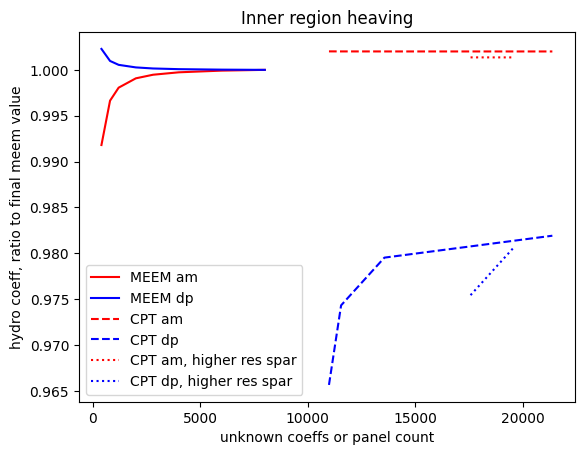

In [ ]:
# Plot data from previous block.
plt.plot([val * 4 for val in vals], [am/ams[-1] for am in ams], color = "red", label = "MEEM am")
plt.plot([val * 4 for val in vals], [dp/dps[-1] for dp in dps], color = "blue", label = "MEEM dp")
plt.plot(pcs, [cpt_am/ams[-1] for cpt_am in cpt_ams], color = "red", label = "CPT am", linestyle = "--")
plt.plot(pcs, [cpt_dp/dps[-1] for cpt_dp in cpt_dps], color = "blue", label = "CPT dp", linestyle = "--")
plt.plot(pcs_denser, [cpt_am/ams[-1] for cpt_am in cpt_denser_ams], color = "red", label = "CPT am, higher res spar", linestyle = ":")
plt.plot(pcs_denser, [cpt_dp/dps[-1] for cpt_dp in cpt_denser_dps], color = "blue", label = "CPT dp, higher res spar", linestyle = ":")
plt.xlabel("unknown coeffs or panel count")
plt.ylabel("hydro coeff, ratio to final meem value")
plt.legend()
plt.title("Inner region heaving")
plt.show()